In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
random_seed = 2025
fix_seed(random_seed)

## Human Cerebellum

In [ ]:
adata = sc.read_h5ad('./cerebellum.h5ad')
adata.X[adata.X.nonzero()] = 1
adata.var_names_make_unique()
pca_feat(adata, n_comps=100)
adata.obsm['feat'] = adata.obsm['X_pca'].copy()

In [3]:
adata = construct_neighbor_graph(adata, loc_neighbors=6, gene_neighbors=2, com_neighbors=1)

In [4]:
model = SPHERE(adata, device=device, learning_rate=0.0005, epochs=200, dim_hid=64, lambda_fea_recon=0.1,lambda_spa_recon=1,
               lambda_recon=5,lambda_con=10)

/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:148: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [5]:
output = model.train()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)

100%|██████████| 200/200 [00:03<00:00, 56.44it/s]


Model training finished!



In [6]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=6, covariance_type='tied', random_state=0)
y = gm.fit_predict(adata.obsm['latent'], y=None)
adata.obs["leiden"] = pd.Series(y, index=adata.obs.index, dtype='category')

In [7]:
coords = adata.obsm["spatial"]
spatial_rot90_flip = np.zeros_like(coords)
spatial_rot90_flip[:, 0] = -coords[:, 1]
spatial_rot90_flip[:, 1] = -coords[:, 0]
adata.obsm["spatial"] = spatial_rot90_flip

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


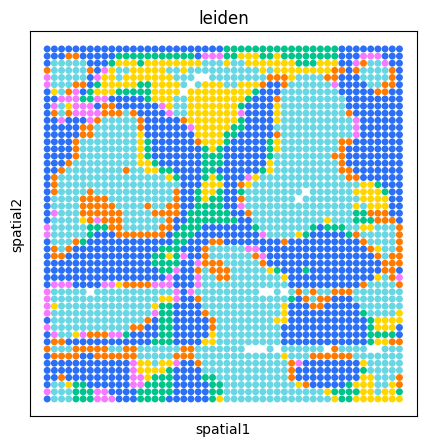

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)
plot_color=["#FFD600",  "#F67AFF", "#68D6E3", "#FF7A00", "#00C48C", "#2A6FF5"]
sc.pl.embedding(adata, basis="spatial",
                color="leiden",
                s=100,
                show=True,
                palette=plot_color,legend_loc=None)